In [1]:
include("../src/PowerPhaseRetrieval.jl")
import PowerModels as PM
import .PowerPhaseRetrieval as PPR
using JuMP,Ipopt
using LinearAlgebra,Random,Statistics
using Plots,LaTeXStrings

[info | PowerModels]: Suppressing information and warning messages for the rest of this session.  Use the Memento package for more fine-grained control of logging.


┌ Warning: Replacing docs for `Main.PowerPhaseRetrieval.compute_basic_ac_pf! :: Tuple{Dict{String, Any}}` in module `Main.PowerPhaseRetrieval`
└ @ Base.Docs docs/Docs.jl:240
┌ Warning: Replacing docs for `Main.PowerPhaseRetrieval.calc_closest_rank_r :: Tuple{Matrix, Integer}` in module `Main.PowerPhaseRetrieval`
└ @ Base.Docs docs/Docs.jl:240


┌ Warning: Replacing docs for `Main.PowerPhaseRetrieval.calc_closest_rank_r :: Tuple{Matrix, Integer}` in module `Main.PowerPhaseRetrieval`
└ @ Base.Docs docs/Docs.jl:240


In [2]:
function est_bus_voltage_phase(va_nom,∂pv,∂qv,vm_obs,f_x_obs,q_nom,p_nom,∂pθ_true,∂qθ_true)
    n_bus = length(va_nom)
    #make phase retrieval model
    println("test")
    model = Model(Ipopt.Optimizer)
    #set_silent(model)

    #----- Variables and expressions
    #--- Phase VariableS
    @variable(model,θ[1:n_bus])

    #--- Phase jacobian variables
    @variable(model,∂pθ[1:n_bus,1:n_bus])
    @variable(model,∂qθ[1:n_bus,1:n_bus])

    #---- Expressions
    #- Grid state with unknown phase angles.
    x = [θ; vm_obs]
    #- Jacobian matrix
    J = [
        ∂pθ ∂pv;
        ∂qθ ∂qv
    ]
    #- Residual expression
    @variable(model,resid[1:2*n_bus])
    @constraint(model,resid .== J*x .- f_x_obs)

    #----- Constraints
    #Jacobian physics constraints
    for i =1:n_bus
        @constraint(model,
            ∂pθ[i,i] == vm_obs[i]*∂qv[i,i] - 2*q_nom[i]
        )
        @constraint(model,
            ∂qθ[i,i] == -vm_obs[i]*∂pv[i,i] + 2*p_nom[i]
        )
        @constraint(model,
            [k=1:n_bus; k!= i],
            ∂pθ[i,k] == vm_obs[k]*∂qv[i,k]
        )
        @constraint(model,
            [k=1:n_bus; k!=i],
            ∂qθ[i,k] == -vm_obs[k]*∂pv[i,k]
    )
    end

    #----- Objective - min sum of square errors
    @objective(model,Min,sum(resid.^2))

    optimize!(model)

    #construct phasor voltages
    θ_hat = value.(θ)
    v_rect_hat = vm_obs .* (cos.(θ_hat) + sin.(θ_hat) .* im)
    v_rect_true = vm_obs .* (cos.(va_nom) + sin.(va_nom) .* im)

    #------- Construct current phasors
    L_rect_true = conj.((p_nom .+ q_nom.*im)./ v_rect_true)
    L_rect_hat = conj.((p_nom .+ q_nom.*im)./v_rect_hat)
    
    #param covariance
    ∂pθ = value.(∂pθ)
    ∂qθ = value.(∂qθ)
    
    Je = Matrix([
        ∂pθ ∂pv;
        ∂qθ ∂qv
    ])
    #Construct the standard error:
    #se = sqrt(sum((va_nom.- θ_hat).^2)/(length(θ_hat)-2))
    mse = (1/length(resid))*sum(value.(resid).^2)#(1/length(va_nom))*sum((va_nom.- θ_hat).^2)
    se = sqrt.(diag(inv(Je'*Je))*mse)[1:n_bus]#sqrt.(diag(inv(Jph'*Jph )) * mse)#sqrt.(diag(inv(∂pθ' * ∂pθ + ∂qθ' * ∂qθ))*mse)

    #construct covariance of the error
    err_cov = diag((va_nom .- θ_hat)*(va_nom .- θ_hat)')
    

    #th_std = sqrt.(diag((inv(Je'*Je)*Je')*(va_nom*va_nom')*(Je*inv(Je'*Je))))
    
    

    #Return the results dict
    return Dict(
        "th_hat"=>θ_hat,
        "th_true"=>va_nom,
        "v_rect_hat"=>v_rect_hat,
        "dpth"=>value.(∂pθ),
        "dqth"=>value.(∂qθ),
        "th_sq_errs" => (abs.(va_nom .- θ_hat)).^2,
        "th_rel_err"=> norm(va_nom- θ_hat)/norm(va_nom)*100,
        "std_err"=>se ,
        "err_cov"=>err_cov,
        # "th_std="=>th_std,
        "dpth_rel_err"=>norm(value.(∂pθ)- ∂pθ_true)/norm(∂pθ_true)*100,
        "dqth_rel_err"=>norm(value.(∂qθ)- ∂qθ_true)/norm(∂qθ_true)*100,
        "L_rel_err"=> norm(L_rect_true .- L_rect_hat)./(norm(L_rect_true))*100
        #"v_rect_rel_err"=> norm(v_rect_nom-v_rect_hat)/norm(v_rect_nom)*100
    )
end

est_bus_voltage_phase (generic function with 1 method)

In [3]:
net = PM.make_basic_network(PM.parse_file("../data/case_RTS_GMLC.m"))
PM.compute_ac_pf!(net)
x_pm,s_pm = PM.calc_basic_bus_voltage(net),PM.calc_basic_bus_injection(net)

(ComplexF64[1.0361349515573042 - 0.15571234717049007im, 1.036028266253565 - 0.15682200235819138im, 1.002110172629621 - 0.13973752139932694im, 1.0002949668544117 - 0.18913662515010876im, 1.0172913326346031 - 0.19573641596839678im, 1.005852572522352 - 0.23436874092380902im, 1.0352997282164838 - 0.0667605815947924im, 0.9961601816266125 - 0.16157459347719103im, 1.0156214997594983 - 0.15027752751428128im, 1.0336398650882417 - 0.18524981254513792im  …  1.0453280922805404 + 0.022950291700238334im, 1.0433664952593207 + 0.09515186610628719im, 1.0436414307512143 + 0.11538008502145593im, 1.039264851859264 + 0.01690846026507476im, 1.042704594266573 + 0.045993045906061965im, 1.0421767967381523 + 0.12793562576782042im, 1.022984465126047 + 0.23664907375854194im, 1.0472869120339907 + 0.07543290980936841im, 0.9975672803268065 - 0.09380365639268246im, 1.0457680898026311 + 0.0852288804623008im], ComplexF64[0.6000000000000001 - 0.11793183944531578im, 0.7100000000000002 - 0.13299290132831343im, -1.8 - 0.37

In [4]:
net = PM.make_basic_network(PM.parse_file("../data/case_RTS_GMLC.m"))
nr_data = PPR.calc_nr_pf!(net)
sel_bus_idx = PPR.calc_bus_idx_of_type(net,[1])
n_bus = length(sel_bus_idx)
f = nr_data.f
L = nr_data.L_inj
S = nr_data.S_inj
x = nr_data.x
jacs = nr_data.jacs
delta_vm = nr_data.delta_vm
delta_va = nr_data.delta_va
results= []
for (k,(fk,Lk,xk,Sk,jack)) in enumerate(zip(f,L,x,S,jacs))
    #Mismatch changes
    Δpk,Δqk = real.(fk)[sel_bus_idx],imag.(fk)[sel_bus_idx]
    
    #State
    vk,θk = abs.(xk)[sel_bus_idx],angle.(xk)[sel_bus_idx]
    
    
    #Nominal injections and jacobians
    pk,qk = real.(Sk)[sel_bus_idx],imag.(Sk)[sel_bus_idx]
    ∂pvk,∂qvk = jack.pv[sel_bus_idx,sel_bus_idx],jack.qv[sel_bus_idx,sel_bus_idx]
    ∂pθk,∂qθk = jack.pth[sel_bus_idx,sel_bus_idx],jack.qth[sel_bus_idx,sel_bus_idx]
    
    #Observed mismatches
    f_x_obs = [∂pθk ∂pvk; ∂qθk ∂qvk]*[θk;vk]
    p_obs,q_obs = f_x_obs[1:n_bus],f_x_obs[n_bus+1:end]
    
    #Observed current injection
    #Lk = conj.((p_obs .+ q_obs.*im)./(xk[sel_bus_idx]))
    #Lk = Lk[sel_bus_idx]
    push!(results,est_bus_voltage_phase(θk,∂pvk,∂qvk,vk,[p_obs;q_obs],qk,pk,∂pθk,∂qθk)) 
end

test



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     9680
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3280

Total number of variables............................:     3320
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3280
Total number of inequality co

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     9680
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3280

Total number of variables............................:     3320
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3280
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.51e+02 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     9680
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3280

Total number of variables............................:     3320
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3280
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.51e+02 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     9680
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3280

Total number of variables............................:     3320
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3280
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.51e+02 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     9680
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3280

Total number of variables............................:     3320
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3280
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.51e+02 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     9680
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3280

Total number of variables............................:     3320
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3280
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.51e+02 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [142]:
"""
Make matrices of the angle states at every iteration of the Newton-Raphson algorithm
"""
function make_theta_series(results)
    th_true = [d["th_true"] for d in results] #true theta
    th_hat = [d["th_hat"] for d in results]
    M_true = zeros(length(th_hat),length(th_hat[1]))
    M_hat = zeros(length(th_hat),length(th_hat[1]))
    for (i,(th_true_i,th_hat_i)) in enumerate(zip(th_true,th_hat))
        M_true[i,:] = th_true_i
        M_hat[i,:] = th_hat_i
    end
    return M_true,M_hat
end

make_theta_series

In [6]:
th_rel_err = [d["th_rel_err"] for d in results] #voltage phase
L_rel_err = [d["L_rel_err"] for d in results] #current
dpth_rel_err = [d["dpth_rel_err"] for d in results] #sensitivities
dqth_rel_err = [d["dqth_rel_err"] for d in results] #sensitivities

6-element Vector{Float64}:
 5.096297279073461e-14
 3.381247732931737e-14
 5.118286930262779e-14
 3.00131098241511e-14
 6.779612236485346e-14
 5.582721366379534e-14

In [58]:
size_pt

(324.0, 200.21257137207408)

### Plot the thetas at every iteration

In [39]:
theme(:ggplot2)
x = [i for i in 1:length(th_rel_err)]
p = plot(x,
    th_rel_err,
    label=L"$\theta$",
    line=:dot,
    marker=:square,
    ms=5,
    lw=3,
    fillalpha=0.15,
    alpha=0.6,
)
plot!(x,
    dpth_rel_err,
    label=L"$\partial p / \partial \theta$",
    line=:dot,
    marker=:square,
    ms=5,
    lw=3,
    fillalpha=0.15,
    alpha=0.6,
)
plot!(x,
    dqth_rel_err,
    label=L"$\partial q / \partial \theta$",
    line=:dot,
    marker=:square,
    ms=5,
    lw=3,
    fillalpha=0.15,
    alpha=0.6,
)
plot!(x,
    L_rel_err,
    label=L"$\ell$",
    line=:dot,
    marker=:square,
    ms=5,
    lw=3,
    fillalpha=0.15,
    alpha=0.6,
)
xlabel!(L"Iteration $k=1,\dots,$")
ylabel!(L"$\|| x_k- \hat{x}_k \|| / \|| x_k\|| \times 100 \ (\%)$")
title!("RTS_GMLC: NR Phase Retrieval Performance")
savefig(p,"../figures/spring_23/nr_iterations/rts_gmlc_v3.pdf")

"/home/sam/research/PowerPhaseRetrieval.jl/figures/spring_23/nr_iterations/rts_gmlc_v3.pdf"

In [61]:
set_theme!(theme_ggplot2())
size_in_inches = (4.5,4.5/1.61828)
size_pt = 72 .* size_in_inches
f = Figure(resolution=size_pt,fontsize=12) #Figure(resolution=size_in_pixels)
ax = Axis(
    f[1,1],
    title="NR Phase Retrieval Performance (Case RTS_GMLC)",
    xlabel=L"Iteration $k=1,\dots$",
    ylabel=L"Relative Error $\frac{\left|| x_k- \hat{x}_k \right||}{\left|| x_k\right||} \times 100 $ (%)"#L"$\frac{\lVert \theta_k - \hat{\theta}_k \rVert_2}{\lVert\theta_k\rVert_2}$"
)
x = [i for i in 1:length(th_rel_err)]
scatterlines!(ax,x,th_rel_err,label=L"$\theta$")
scatterlines!(ax,x,dpth_rel_err,label=L"$\partial p / \partial \theta$")
scatterlines!(ax,x,dqth_rel_err,label=L"$\partial q / \partial \theta$")
scatterlines!(ax,x,L_rel_err,label=L"$\ell$")
ylims!(ax,0,9e-14)
axislegend("Quantity",orientation=:horizontal,position=:rt,patchcolor=:transparent)
resize_to_layout!(f)

(324.0f0, 200.0f0)

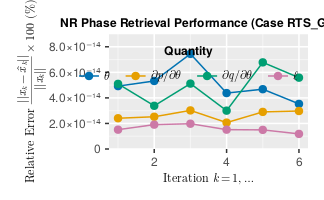

In [62]:
f

In [38]:
save("../figures/spring_23/nr_iterations/rts_gmlc_v2.pdf",f,px_per_unit=1)

CairoMakie.Screen{PDF}


In [302]:
pwd()

"/home/sam/Research/PowerPhaseRetrieval/tests"